# Use Transfer Learning for Sun Spotter
## Try different pre trained models e.g. resnet_v2_152, inception_resnet_v2, mobilenet etc.

In [1]:
import tensorflow as tf
import numpy as np
import time
import PIL.Image as Image
import tensorflow_hub as hub
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [2]:
keras.__version__

'2.6.0'

In [3]:
#set some variables
executeLocal = True

In [4]:
if(executeLocal == False):
  from google.colab import drive
  drive.mount('/content/drive')

In [23]:
# If the GPU is enabled, it will give the following output −-> '/device:GPU:0'
tf.test.gpu_device_name()

''

## Use a pretrained model

### Preparation to make it easy to try out different models

#### Use head-less pretrained Model for CNN
We tried the following models:
* Use trainable=False to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.   
* Use trainable=True to fine tune the variables in the feature extractor layer.
   
| "Model"        | "Fine tuned?"| "Training loss"  | "Training accuracy"  | "Validation loss" | "Validation accuracy" | "Commments"
| :------------- |:-------------:| :-------------:| :-----: |:-----:| :-----: | ------------- :|
| resnet_v2_50  | yes              |0.7248 | 0.9413  |  0.8801 | 0.8594 | generalizes bad (always 100% confidence in one class)
| resnet_v2_50  | no               |0.8994 |  0.5831  | 0.8569 | 0.5375 |generalizes bad (always 100% confidence in one class)
| inception_resnet_v2   | yes      | 1.0882 | 0.8742 | 1.8426 | 0.5250 |generalizes bad (always 100% confidence in one class)
| inception_resnet_v2   | no      |   0.6287 |0.8308  | 0.9929 | 0.6219 |generalizes bad (always 100% confidence in one class)
| mobilenet_v2_140_224| yes      |   0.5639| 0.9345 |  1.0495 | 0.6125 | second best results
| mobilenet_v2_140_224| no      |  0.6338 |0.9345  |0.7113 | 0.7750 | **_best validation loss & generalizes best_**

#### Own CNN-Model with 5 convolution layers
| "Model"        | "Fine tuned?"| "Training loss"  | "Training accuracy"  | "Validation loss" | "Validation accuracy" | "Commments"
| :------------- |:-------------:| :-------------:| :-----: |:-----:| :-----: | ------------- :|
| selfmade model  | -              | 0.3565 |  0.8442  |  0.3142 | 0.8592 | lowest loss and high accuracy but generalizes not good



In [7]:
model_name = "mobilenet_v2_035_244" 
#@param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/google/efficientnet/b0/feature-vector/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",  
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
  "mobilenet_v2_035_244": "https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/feature_vector/5",  
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "bit_m-r50x1": "https://tfhub.dev/google/bit/m-r50x1/1",
  "efficientnet_v2_imagenet21k_s":"https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",

}

model_image_size_map = {
  "efficientnet_b0": 224,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "efficientnet_v2_imagenet21k_s":384,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

Selected model: mobilenet_v2_035_244 : https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/feature_vector/5
Input size (224, 224)


## Create callback instances
### Setup folder where to save logs for tensorboard, one folder for every run

In [8]:
#setup folder where to save logs for tensorflow
def get_run_logdir(modelName, local):
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S_"+modelName)
  if(local):
    result = os.path.join(root_logdir, run_id)
  else:
    result = root_logdir + "/" + run_id
  return result
run_logdir = ""
if(executeLocal == True):
  root_logdir = os.path.join(os.curdir,"my_logs")  
else:
 root_logdir = "/content/drive/MyDrive/Colab Notebooks/my_logs"
 
  
run_logdir = get_run_logdir(model_name, executeLocal)


In [26]:
#create keras Tensorboard callback
#if(executeLocal == True):
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### Setup callback for ModelCheckpoint to save the model

In [27]:
#create keras ModelCheckpoint callback
if(executeLocal == True):
 checkpoint_cb = keras.callbacks.ModelCheckpoint("sunSpotter_keras_transferLearning_model_"+model_name+".h5")
else :
 checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = "content/drive/MyDrive/Colab Notebooks/h5Models/sunSpotter_keras_transferLearning_model_"+model_name+".h5",
   save_freq = 5000,
   save_weights_only = True,
   verbose = 2)

### Setup callback for Early Stopping

In [28]:
#create keras early stopping callback will be used later on
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### Load the data set

We uses a dataset of about 735 sunny photos and 854 not sunny of different landscapes from real webcams. The dataset contains 2 sub-directories, one per class:

```
/
  notSunny/
  sunny/  
```

In [5]:
import pathlib

if (executeLocal == True):
  data_dir = "..\..\data\images-classified"
  data_dir = pathlib.Path(data_dir)
  print(data_dir)

  testData_dir = "..\..\\testData\images-classified"
  testData_dir = pathlib.Path(testData_dir)
  print(testData_dir)
else:
  data_dir = "/content/drive/MyDrive/Colab Notebooks/images-classified"
  data_dir = pathlib.Path(data_dir)
  print(data_dir)

  testData_dir = "/content/drive/MyDrive/Colab Notebooks/testData/images-classified"
  testData_dir = pathlib.Path(testData_dir)
  print(testData_dir)
    

..\..\data\images-classified
..\..\testData\images-classified


Load and preprocess the data set (in the code under it assumes that every class is contained in a different subfolder, but that can be adapted). In addition perform some data augmentation on the training data. 
Split the dataset in a validation an a training part which will be used by the model. Let's use 80% of the images for training, and 20% for validation. Use a second source as test data. The items for test are situated in a separate folder.


mobile-net, den kleineren verwenend (noch kein fine tuning)
nur 1 dropout layer bevor dense
30% 40% dropout

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=.20,         
    shear_range=0.2,    
    #zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40) # add data augmentation transformations
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=.20)#no data augmentation in the validation set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)#no data augmentation in the test set    

train_generator = train_datagen.flow_from_directory(
    data_dir, 
    subset="training", 
    shuffle=False,
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    interpolation="bilinear",
    seed=None)    
valid_generator = valid_datagen.flow_from_directory(
    data_dir, 
    subset="validation", 
    shuffle=False, 
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    interpolation="bilinear")
test_generator = test_datagen.flow_from_directory(
    testData_dir, 
    shuffle=False, 
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    interpolation="bilinear")         

Found 2298 images belonging to 2 classes.
Found 573 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [31]:
# iterate over the batches yielded by the dataset.
#for data, labels in train_generator:
#   print(data.shape)  # (32, 200, 200, 3)
#   print(data.dtype)  # float32
#   print(labels.shape)  # (32,)
#   print(labels.dtype)  # int32

### Defining the model

First let's create the feature extractor. Use trainable=False to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [32]:
feature_extractor_layer = hub.KerasLayer(model_handle, trainable=False)

Now let's attach a classification head after the feature extractor layer. Thta's mean we need to wrap the hub layer 
in a tf.keras.Sequential model, and add a new classification layer.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy. Just change to trainable = True.  

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor_layer,   
    #layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(rate=0.3),    
    #tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
    #tf.keras.layers.Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    #tf.keras.layers.Dense(train_generator.num_classes, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    tf.keras.layers.Dense(train_generator.num_classes)
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              410208    
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 412,770
Trainable params: 2,562
Non-trainable params: 410,208
_________________________________________________________________


### Compile & Train the model 

In [64]:
model.compile(
  #optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.7), 
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9), 
  # optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9), 
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.2),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [65]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
epochs = 20

if (executeLocal == True):
  hist = model.fit(
      train_generator,
      epochs=epochs, steps_per_epoch=steps_per_epoch,
      validation_data=valid_generator,
      validation_steps=validation_steps,  callbacks = [tensorboard_cb, early_stopping_cb, checkpoint_cb]).history
else:
  hist = model.fit(
      train_generator,
      epochs=epochs, steps_per_epoch=steps_per_epoch,
      validation_data=valid_generator,
      validation_steps=validation_steps,  callbacks = [tensorboard_cb, early_stopping_cb, checkpoint_cb]).history

Epoch 1/20
71/71 [==============================] - 210s 3s/step - loss: 0.7630 - accuracy: 0.8244 - val_loss: 0.6210 - val_accuracy: 0.8199
Epoch 2/20
71/71 [==============================] - 159s 2s/step - loss: 0.6582 - accuracy: 0.8310 - val_loss: 0.4474 - val_accuracy: 0.8805
Epoch 3/20
71/71 [==============================] - 170s 2s/step - loss: 0.5473 - accuracy: 0.8566 - val_loss: 0.4198 - val_accuracy: 0.8824
Epoch 4/20
71/71 [==============================] - 163s 2s/step - loss: 0.7593 - accuracy: 0.7771 - val_loss: 0.6063 - val_accuracy: 0.8217
Epoch 5/20
71/71 [==============================] - 172s 2s/step - loss: 0.6399 - accuracy: 0.8182 - val_loss: 0.4396 - val_accuracy: 0.8842
Epoch 6/20
71/71 [==============================] - 153s 2s/step - loss: 0.6344 - accuracy: 0.8376 - val_loss: 0.4737 - val_accuracy: 0.8474


In [78]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

keras_layer
dropout
dense


In [36]:

#hist = tf.keras.callbacks.History()
print(hist)

# check the keys of history object
#print(hist.history.keys())

{'loss': [1.4251360893249512, 0.5270065069198608, 0.5336388349533081, 0.6074753403663635, 0.5207502841949463, 0.7912706136703491, 0.4640350937843323, 0.5154533982276917, 0.5268208384513855, 0.5806711316108704, 0.4633927047252655], 'accuracy': [0.6244483590126038, 0.813768744468689, 0.8124448657035828, 0.8005295395851135, 0.8199470639228821, 0.7519859075546265, 0.8539276123046875, 0.8239188194274902, 0.8353927731513977, 0.8120035529136658, 0.8574580550193787], 'val_loss': [0.6181917786598206, 0.7534620761871338, 0.43265336751937866, 1.0010156631469727, 0.8275065422058105, 0.41126319766044617, 0.4458622932434082, 0.3803195059299469, 0.506363570690155, 0.41810181736946106, 0.3902948498725891], 'val_accuracy': [0.7334558963775635, 0.6323529481887817, 0.8566176295280457, 0.5827205777168274, 0.623161792755127, 0.8786764740943909, 0.845588207244873, 0.8970588445663452, 0.8088235259056091, 0.8713235259056091, 0.8952205777168274]}


Let's track the training (one can also use TensorBoard!)

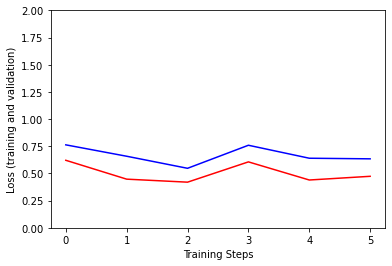

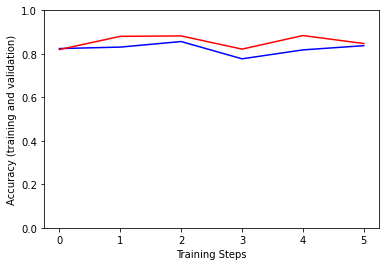

In [66]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], color="blue", label='Training Loss')
plt.plot(hist["val_loss"], color="red", label='Validation Loss')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], color="blue", label='Training Loss')
plt.plot(hist["val_accuracy"], color="red", label='Validation Loss')

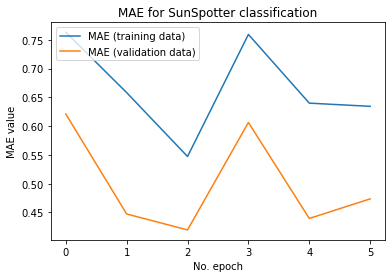

In [67]:
# Plot hist: MAE
plt.plot(hist['loss'], label='MAE (training data)')
plt.plot(hist['val_loss'], label='MAE (validation data)')
plt.title('MAE for SunSpotter classification')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

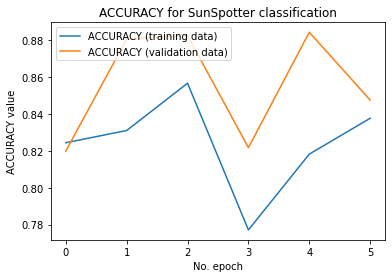

In [68]:
# Plot history: ACCURACY
plt.plot(hist['accuracy'], label='ACCURACY (training data)')
plt.plot(hist['val_accuracy'], label='ACCURACY (validation data)')
plt.title('ACCURACY for SunSpotter classification')
plt.ylabel('ACCURACY value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Create plots of loss and accuracy on the training and validation sets.

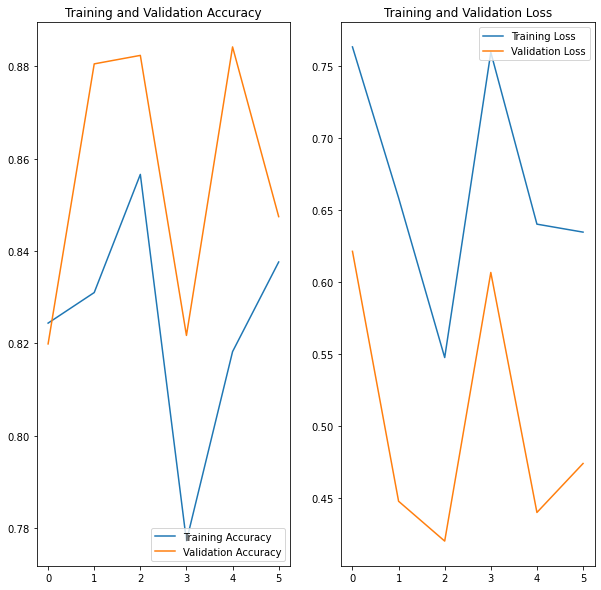

In [69]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']


#epochs_range = range(epochs)
# Get number of epochs
epochs_range = range(len(acc))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Reload a pretrained model

In [13]:
# Reconstruct the model with keras
# model_name_toreload = "mobilenet_v2_140_224"
# pretrained_model_path = f"./tmp/saved_sunSpotter_model_{model_name}"
loadPretrainedModel = True
if(loadPretrainedModel):
#H5 format
    #pretrained_model_path = f"./sunSpotter_keras_transferLearning_model_mobilenet_v2_140_224_finetuned.h5"
    pretrained_model_path = f"./sunSpotter_keras_transferLearning_model_mobilenet_v2_035_244.h5"

    #pretrained_model_path = f"sunSpotter_keras_transferLearning_model.h5"
    model = keras.models.load_model(pretrained_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              410208    
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 412,770
Trainable params: 2,562
Non-trainable params: 410,208
_________________________________________________________________


## Predict on trainings data

Try out the model on an image from the validation data:

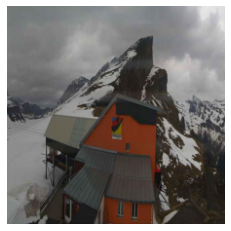

True label: notSunny
Predicted label: notSunny


In [14]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

show the confidence level of the preditions (most likely and least likely):

In [15]:
score = tf.nn.softmax(prediction_scores[0])
# print score of all classes
print(score)
# print score of most likely class
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)
# pring score of least likely class
print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([9.9992585e-01 7.4098352e-05], shape=(2,), dtype=float32)
This image most likely belongs to notSunny with a 99.99 percent confidence.
This image most unlikely belongs to sunny with a 0.01 percent confidence.


## Predict on new data

Result is already quite impressive!

In [44]:
#load test dataset with function image_dataset_from_directory
if (False):
  image_test_count = len(list(testData_dir.glob('*/*.jpg'))) 
  print("Number of test data: {}".format(image_test_count))
  test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      testData_dir,
      seed=123,
      image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
      batch_size=BATCH_SIZE)
  #AUTOTUNE = tf.data.AUTOTUNE
  #test_ds =  test_ds.cache().prefetch(buffer_size=AUTOTUNE)

  class_names = test_ds.class_names
  print(class_names)

  #print(test_ds)
  y = np.concatenate([y for x, y in test_ds], axis=0)
  print(type(y))
  print("True labels: \n{}".format(y))

  predictions = model.predict(test_ds)
  scores = np.empty_like(y)

  #print(y.size)
  #print(len(predictions))
  #print(scores.size)

  for i in range(len(predictions)):
    score = tf.nn.softmax(predictions[i])
    scores[i] = np.argmax(score)
    #print(scores[i])

  print("Predicted labels: \n{}".format((scores)))

  con_mat_df = tf.math.confusion_matrix(labels= y, predictions = scores)

  import seaborn as sns
  figure = plt.figure(figsize=(6, 6))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion Matrix
[[81 19]
 [ 9 91]]
Classification Report
              precision    recall  f1-score   support

   not Sunny       0.90      0.81      0.85       100
       Sunny       0.83      0.91      0.87       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



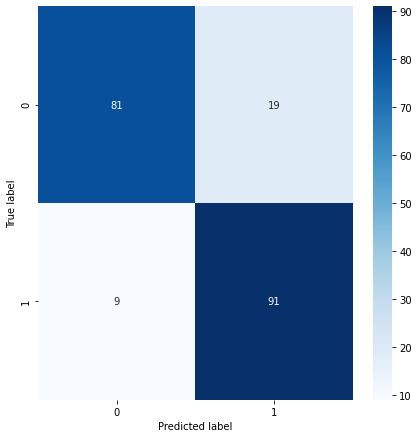

In [16]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(test_generator, 200 // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
con_mat_df = confusion_matrix(test_generator.classes, y_pred)
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['not Sunny', 'Sunny']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

28
notSunny\1_2020-09-07_12-00-00.jpg
notSunny\1_2020-09-24_12-00-00.jpg
notSunny\1_2020-10-29_12-00-00.jpg
notSunny\1_2020-12-12_12-00-00.jpg
notSunny\1_2020-12-15_12-00-00.jpg
notSunny\1_2021-01-13_12-00-00.jpg
notSunny\1_2021-02-02_12-00-00.jpg
notSunny\1_2021-03-11_12-00-00.jpg
notSunny\1_2021-03-12_12-00-00.jpg
notSunny\1_2021-04-05_12-00-00.jpg
notSunny\1_2021-04-26_12-00-00.jpg
notSunny\1_2021-04-27_12-00-00.jpg
notSunny\1_2021-05-05_12-00-00.jpg
notSunny\1_2021-05-10_12-00-00.jpg
notSunny\1_2021-05-29_12-00-00.jpg
notSunny\2_2020-07-15_12-00-00.jpg
notSunny\2_2020-08-02_12-00-00.jpg
notSunny\2_2020-08-13_12-00-00.jpg
notSunny\2_2020-10-08_12-00-00.jpg
sunny\1_2020-09-25_12-00-00.jpg
sunny\1_2020-10-05_12-00-00.jpg
sunny\1_2020-10-16_12-00-rainy.jpg
sunny\1_2020-10-22_12-00-00.jpg
sunny\1_2020-10-24_12-00-00.jpg
sunny\1_2020-11-23_12-00-00.jpg
sunny\1_2020-12-22_12-00-00.jpg
sunny\1_2021-03-14_12-00-00.jpg
sunny\1_2021-04-07_12-00-00.jpg


C:\Users\maryl\AppData\Local\Temp/ipykernel_105892/3945393233.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f= plt.figure()


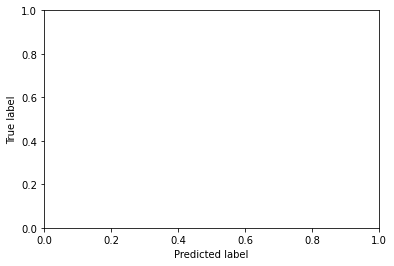

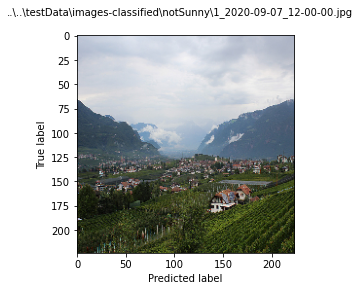

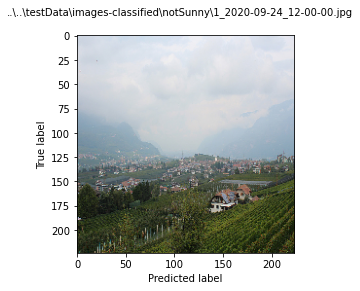

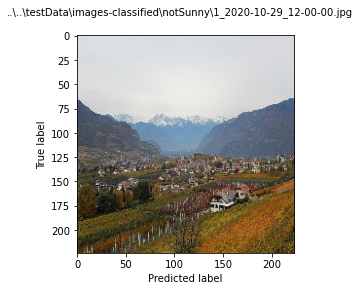

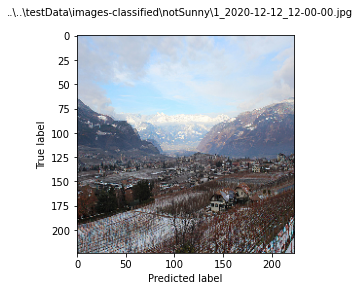

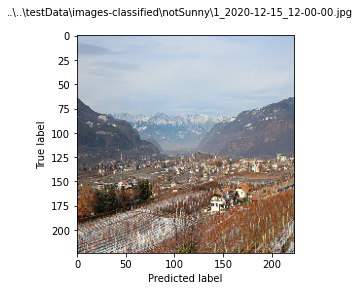

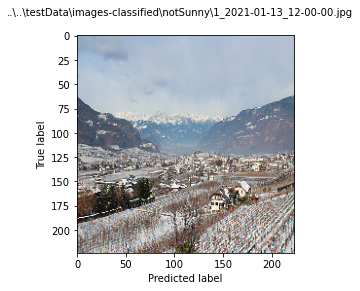

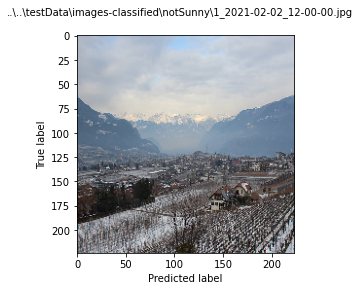

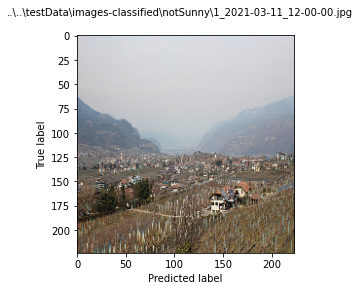

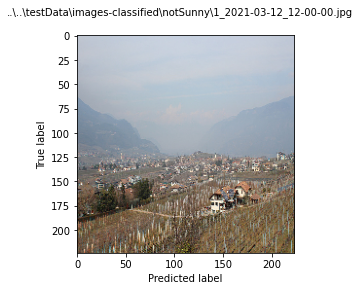

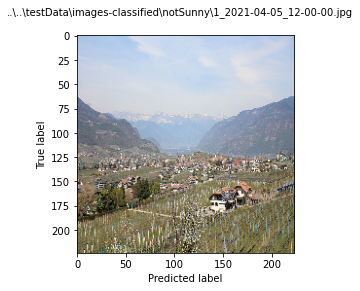

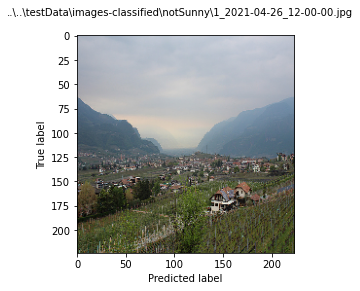

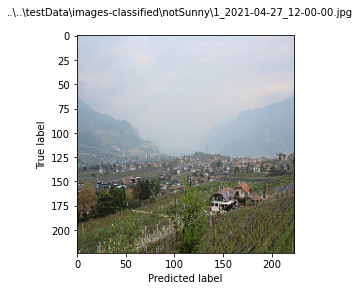

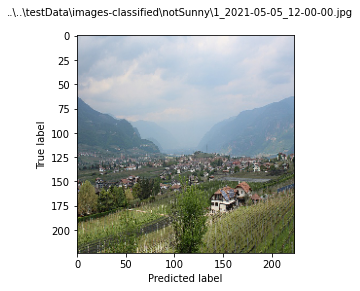

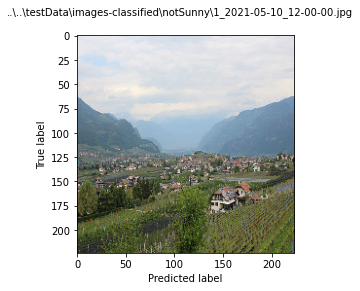

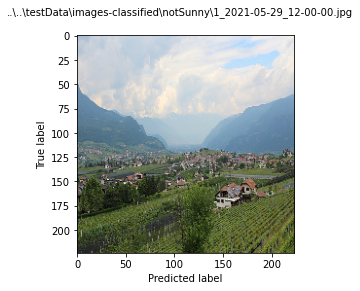

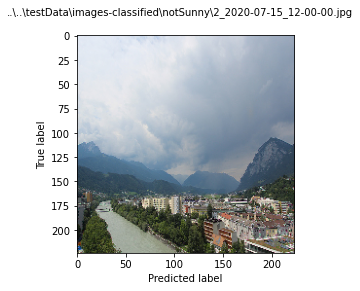

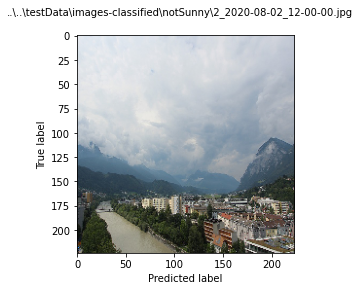

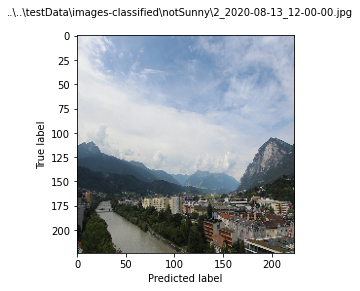

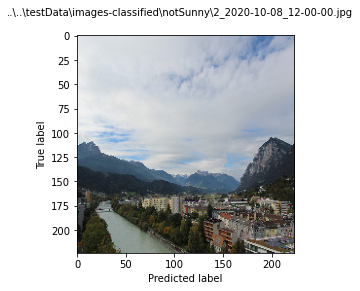

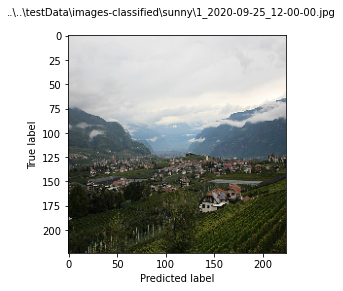

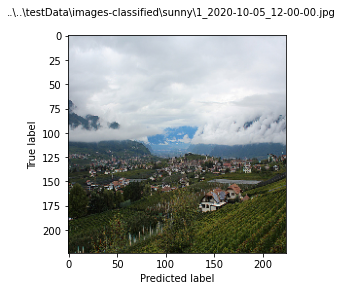

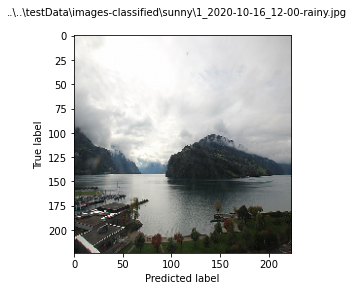

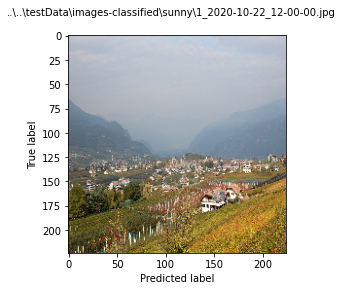

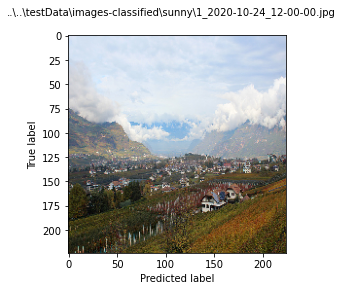

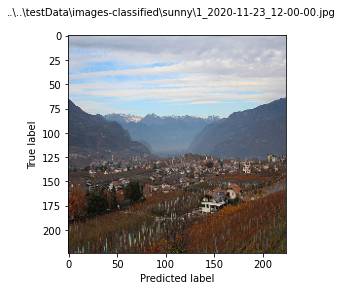

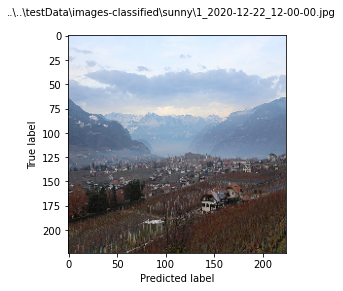

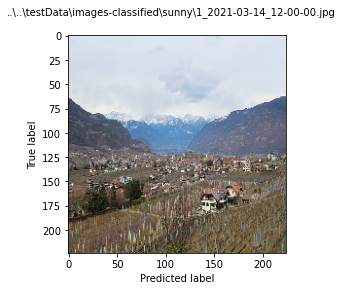

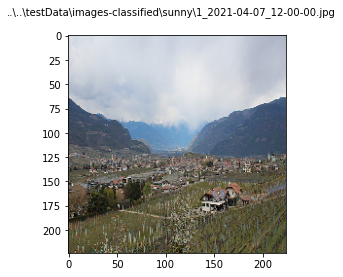

In [17]:
# show missclassified images
Y_pred = model.predict(test_generator, 200 // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
fnames = test_generator.filenames ## fnames is all the filenames/samples used in testing
#print(fnames)
errors = np.where(y_pred != test_generator.classes)[0] ## misclassifications done on the test data where y_pred is the predicted values
print(errors.size)
for i in errors:
    print(fnames[i])

rect = 0, 0, 5, 5    
if(True):
    for i in errors:
        img_path = os.path.join(testData_dir,fnames[i])
        img = keras.preprocessing.image.load_img(img_path, target_size=(pixels,pixels))    
        f= plt.figure()                  
        #f.supylabel("label: "+ fnames[i])
        #f.supxlabel("predicted: " + str(y_pred[i]))
        #f.add_axes(rect)
        #f.get_axes()[0].set_ylabel("label: "+ fnames[i])
        #f.get_axes()[0].set_xlabel("predicted: " + str(y_pred[i])) 
        f.suptitle(img_path, fontsize = 10)
        plt.imshow(img)

#for i in errors:
#    # Debug, plot figure
#    img_path = os.path.join(testData_dir,fnames[i])
#    img = keras.preprocessing.image.load_img(img_path, target_size=(pixels,pixels)) 
#    f = plt.figure()   
#    f.add_subplot(1, errors.size, i)
#    plt.imshow(image)

#plt.show(block=True)

In [46]:
#sunny_url = https://www.foto-webcam.eu/webcam/tschagguns/2021/06/01/1140_hu.jpg
#sunny_url = https://www.foto-webcam.eu/webcam/tschagguns/2021/05/28/1510_hu.jpg
#sunny_url = "https://www.foto-webcam.eu/webcam/tschagguns/2021/06/01/1140_hu.jpg"
#sunny_url = "https://www.foto-webcam.eu/webcam/schroecken/2021/06/09/0830_lm.jpg"
#sunny_url = "https://www.foto-webcam.eu/webcam/feldkirch/2021/06/13/0910_lm.jpg"
sunny_url = "https://www.foto-webcam.eu/webcam/brunnen/2021/06/09/0830_lm.jpg"

sunny_path = tf.keras.utils.get_file('SunnyWheater', origin=sunny_url)

img = keras.preprocessing.image.load_img(
    sunny_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.13348615 0.86651385], shape=(2,), dtype=float32)
This image most likely belongs to sunny with a 86.65 percent confidence.
This image most unlikely belongs to notSunny with a 13.35 percent confidence.


In [47]:
#cloudy_url = "https://www.foto-webcam.eu/webcam/tschagguns/2021/05/27/1510_hu.jpg"
#cloudy_url = "https://www.foto-webcam.eu/webcam/roethis-west/current/180.jpg?1623220198"
#cloudy_url = "https://www.foto-webcam.eu/webcam/saalfelden/2021/06/13/0920_lm.jpg"
#cloudy_url = "https://www.foto-webcam.eu/webcam/zellamsee/2021/06/13/0920_lm.jpg"
cloudy_url = "https://www.foto-webcam.eu/webcam/burgstalleralm/2021/06/13/0920_lm.jpg"

cloudy_path = tf.keras.utils.get_file('CloudyWheater', origin=cloudy_url)

img = keras.preprocessing.image.load_img(
    cloudy_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.786202   0.21379799], shape=(2,), dtype=float32)
This image most likely belongs to notSunny with a 78.62 percent confidence.
This image most unlikely belongs to sunny with a 21.38 percent confidence.


In [48]:
#rainy_url = "https://www.foto-webcam.eu/webcam/zugspitze-nord/2021/06/13/0910_lm.jpg"
rainy_url = "https://www.foto-webcam.eu/webcam/kalsertal/2021/06/13/0920_lm.jpg"
#rainy_url = "https://www.foto-webcam.eu/webcam/pendling-west/2021/06/13/0920_lm.jpg"
rainy_path = tf.keras.utils.get_file('RainyWheater', origin=rainy_url)

img = keras.preprocessing.image.load_img(
    rainy_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.8655845  0.13441545], shape=(2,), dtype=float32)
This image most likely belongs to notSunny with a 86.56 percent confidence.
This image most unlikely belongs to sunny with a 13.44 percent confidence.


## Save the model

In [49]:
saved_model_path = f"./tmp/saved_sunSpotter_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: ./tmp/saved_sunSpotter_model_mobilenet_v2_035_244\assets


INFO:tensorflow:Assets written to: ./tmp/saved_sunSpotter_model_mobilenet_v2_035_244\assets


In [50]:
#Sources: Adapted from A. Géron, Hands-on Machine Learning with Scikit-Learn, Keras, Tensorflow, O’Reilly, 
#https://www.tensorflow.org/hub/tutorials/tf2_image_retraining, https://www.tensorflow.org/tutorials/images/transfer_learning

## Grad-CAM

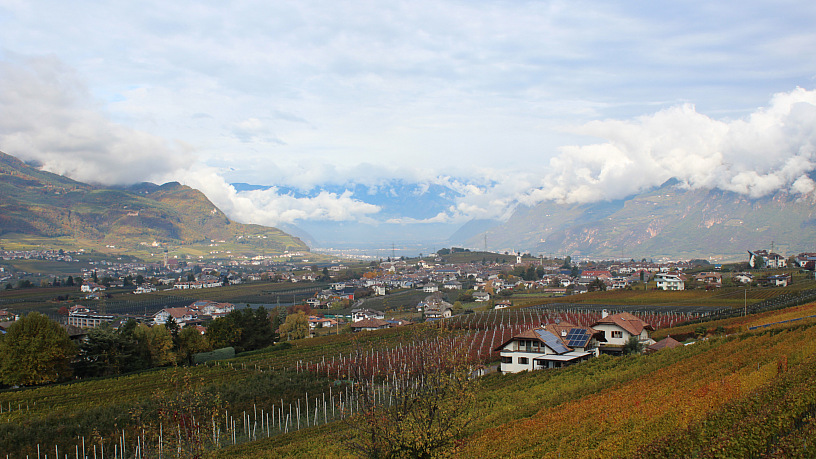

In [20]:
model_builder = keras.applications.xception.Xception
img_size = (pixels, pixels)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "keras_layer"

#missclassified sunny images
#sunny\1_2020-09-25_12-00-00.jpg
#sunny\1_2020-10-05_12-00-00.jpg
#sunny\1_2020-10-16_12-00-rainy.jpg --> why is this picture here?
#sunny\1_2020-10-24_12-00-00.jpg
#sunny\1_2021-04-07_12-00-00.jpg

img_path = os.path.join(testData_dir,"sunny/1_2020-10-24_12-00-00.jpg")
img = keras.preprocessing.image.load_img(img_path, target_size=(pixels,pixels))    

display(Image(img_path))

In [23]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(grads)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [24]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
#heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
#plt.matshow(heatmap)
#plt.show()

[[-0.9745642  0.6278017]]
tf.Tensor([[0.07548261 0.09812412 0.042459   ... 0.02330143 0.00263642 0.13433677]], shape=(1, 1280), dtype=float32)


InvalidArgumentError: In[0] and In[1] ndims must be == 2: 1 [Op:MatMul]